In [1]:
'''
Recursive Feature Elimination.
'''

'\nRecursive Feature Elimination.\n'

In [2]:
random_seed = 42
import numpy as np; np.random.seed(random_seed)
import xgboost
from sklearn.metrics import mean_absolute_error
import pandas as pd
from copy import deepcopy


class HyperParameterOptimizer(object):
    def __init__(self):
        self.model = None
        self.feature_importances_ = None
    
    def fit(self, _train_X, _train_y):
        print(f"Current shape of feature matrix:", _train_X.shape)
        num_boost_round = 99999

        def feval(preds, train_data):
            labels = train_data.get_label()
            return 'mae', mean_absolute_error(labels, preds)
        
        all_results = []
        for max_depth in [4]: # [5, 10, 15, 20, 25]
            for learning_rate in [0.03]:
                for colsample_bytree in [0.33]:
                    for min_child_weight in [6]: # 3, 6, 8, 12
                        train_X = deepcopy(_train_X)
                        train_y = deepcopy(_train_y)
                        dtrain = xgboost.DMatrix(train_X, label=train_y)
                        params = {"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "min_child_weight": min_child_weight, "n_jobs": -1}
                        cv_results = xgboost.cv(
                            params,
                            dtrain,
                            num_boost_round=num_boost_round,
                            seed=random_seed,
                            nfold=10,
                            feval=feval,
                            early_stopping_rounds=20,
                            verbose_eval=False
                        )
                        print(train_X.shape[1], max_depth, learning_rate, colsample_bytree, min_child_weight, np.round(float(cv_results["test-mae-mean"].iloc[len(cv_results["test-mae-mean"])-1]), 4))
                        all_results.append((max_depth, learning_rate, colsample_bytree, min_child_weight, cv_results))
        all_results_df = pd.DataFrame(all_results, columns=["max_depth", "learning_rate", "colsample_bytree", "min_child_weight", "cv_results"])
        all_results_df["best_validation_f1"] = all_results_df["cv_results"].apply(lambda x: x.iloc[len(x)-1]["test-mae-mean"])
        all_results_df = all_results_df.sort_values(by="best_validation_f1", ascending=False).reset_index(drop=True)
        best_parameters = all_results_df.iloc[0]
        best_max_depth = int(best_parameters["max_depth"])
        best_learning_rate = float(best_parameters["learning_rate"])
        best_colsample_bytree = float(best_parameters["colsample_bytree"])
        best_min_child_weight = float(best_parameters["min_child_weight"])
        best_validation_f1 = float(best_parameters["best_validation_f1"])
        best_num_boost_round = int(len(best_parameters["cv_results"]))
        
        print("Current best max_depth:", best_max_depth)
        print("Current best learning_rate:", best_learning_rate)
        print("Current best colsample_bytree:", best_colsample_bytree)
        print("Current best min_child_weight:", best_min_child_weight)
        print("Current best num_boost_round:", best_num_boost_round)
        params = {"max_depth": best_max_depth, "learning_rate": best_learning_rate, "colsample_bytree": best_colsample_bytree, "min_child_weight": best_min_child_weight, "n_jobs": -1}
        
        train_X = deepcopy(_train_X)
        train_y = deepcopy(_train_y)
        dtrain = xgboost.DMatrix(train_X, label=train_y)
        model = xgboost.train(params,
                              dtrain,
                              num_boost_round=best_num_boost_round,
                              verbose_eval=False)
        feature_importances = model.get_score(importance_type='gain')
        feature_importances_list = []
        for i in range(train_X.shape[1]):
            current_key = f'f{i}'
            if current_key in feature_importances:
                feature_importances_list.append(feature_importances[current_key])
            else:
                feature_importances_list.append(0.0)
        print(f"Current best validation f1 score is {np.round(best_validation_f1, 4)}")
        print("############################")
        self.model = model
        self.feature_importances_ = np.array(feature_importances_list)
        return self
    
    def predict(self, X):
        return self.model.predict(xgboost.DMatrix(X))

    def predict_proba(self, X):
        return self.predict(X)
    
    def decision_function(self, X):
        return self.predict(X)
    
    def transform(self, X):
        return self.predict(X)

    def score(self, X=None, y=None):
        return 0.0

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return self

    def _get_tags(self):
        return {"allow_nan": True}

In [3]:
from sklearn.feature_selection import RFE
import sys
sys.path.insert(0, "../src/")
import numpy as np
import pandas as pd
from utils import read_labels

labels_dir = "../data/labels/"
lang = "eng"
labels = read_labels(labels_dir)

extracted_features_dir = "../data/extracted_features/"

book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")

train_X = book_and_averaged_chunk_df.drop(columns=["book_name"])
train_X = train_X[[column for column in train_X.columns if "average_sentence_embedding" not in column]].values
train_y = book_and_averaged_chunk_df["book_name"].apply(lambda x: labels[x]).values

hpo = HyperParameterOptimizer()
rfe = RFE(hpo, step=10, n_features_to_select=10, verbose=0)
rfe.fit(train_X, train_y)

Current shape of feature matrix: (606, 1031)
1031 4 0.03 0.33 6 0.1752
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 0.33
Current best min_child_weight: 6.0
Current best num_boost_round: 849
Current best validation f1 score is 0.1752
############################
Current shape of feature matrix: (606, 1021)
1021 4 0.03 0.33 6 0.1752
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 0.33
Current best min_child_weight: 6.0
Current best num_boost_round: 931
Current best validation f1 score is 0.1752
############################
Current shape of feature matrix: (606, 1011)
1011 4 0.03 0.33 6 0.1752
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 0.33
Current best min_child_weight: 6.0
Current best num_boost_round: 1295
Current best validation f1 score is 0.1752
############################
Current shape of feature matrix: (606, 1001)
1001 4 0.03 0.33 6 0.1739
Current

761 4 0.03 0.33 6 0.1719
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 0.33
Current best min_child_weight: 6.0
Current best num_boost_round: 1313
Current best validation f1 score is 0.1719
############################
Current shape of feature matrix: (606, 751)
751 4 0.03 0.33 6 0.1717
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 0.33
Current best min_child_weight: 6.0
Current best num_boost_round: 1269
Current best validation f1 score is 0.1717
############################
Current shape of feature matrix: (606, 741)
741 4 0.03 0.33 6 0.1719
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 0.33
Current best min_child_weight: 6.0
Current best num_boost_round: 1234
Current best validation f1 score is 0.1719
############################
Current shape of feature matrix: (606, 731)
731 4 0.03 0.33 6 0.1717
Current best max_depth: 4
Current best learning_rate: 0.0

491 4 0.03 0.33 6 0.1675
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 0.33
Current best min_child_weight: 6.0
Current best num_boost_round: 1295
Current best validation f1 score is 0.1675
############################
Current shape of feature matrix: (606, 481)
481 4 0.03 0.33 6 0.1665
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 0.33
Current best min_child_weight: 6.0
Current best num_boost_round: 1143
Current best validation f1 score is 0.1665
############################
Current shape of feature matrix: (606, 471)
471 4 0.03 0.33 6 0.1672
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 0.33
Current best min_child_weight: 6.0
Current best num_boost_round: 1302
Current best validation f1 score is 0.1672
############################
Current shape of feature matrix: (606, 461)
461 4 0.03 0.33 6 0.1676
Current best max_depth: 4
Current best learning_rate: 0.0

221 4 0.03 0.33 6 0.1564
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 0.33
Current best min_child_weight: 6.0
Current best num_boost_round: 1190
Current best validation f1 score is 0.1564
############################
Current shape of feature matrix: (606, 211)
211 4 0.03 0.33 6 0.1585
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 0.33
Current best min_child_weight: 6.0
Current best num_boost_round: 1152
Current best validation f1 score is 0.1585
############################
Current shape of feature matrix: (606, 201)
201 4 0.03 0.33 6 0.1572
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 0.33
Current best min_child_weight: 6.0
Current best num_boost_round: 1123
Current best validation f1 score is 0.1572
############################
Current shape of feature matrix: (606, 191)
191 4 0.03 0.33 6 0.1537
Current best max_depth: 4
Current best learning_rate: 0.0

RFE(estimator=<__main__.HyperParameterOptimizer object at 0x7f061811ddc0>,
    n_features_to_select=10, step=10)

In [18]:
rfe

RFE(estimator=<__main__.HyperParameterOptimizer object at 0x7f061811ddc0>,
    n_features_to_select=10, step=10)

In [20]:
import pickle
f= open('handcrafted_features_eng_rfe_current_best_result_new_rfe.pkl', 'wb')
pickle.dump(rfe, f)
f.close
f= open('handcrafted_features_eng_rfe_current_best_result_new_hpo.pkl', 'wb')
pickle.dump(hpo, f)
f.close

<function BufferedWriter.close>

In [5]:
num_boost_round = 551

In [6]:
book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
book_and_averaged_chunk_df = book_and_averaged_chunk_df.drop(columns=["book_name"])
book_and_averaged_chunk_df = book_and_averaged_chunk_df[[column for column in book_and_averaged_chunk_df.columns if "average_sentence_embedding" not in column]]
best_features = book_and_averaged_chunk_df.columns[np.argwhere((rfe.ranking_ <= 7) == True).T[0]].tolist()
print(len(best_features))
print(best_features)

61
['100_most_common_1gram_stopword_True_that', '100_most_common_1gram_stopword_True_as', '100_most_common_1gram_stopword_True_but', '100_most_common_1gram_stopword_True_on', '100_most_common_1gram_stopword_True_well', '100_most_common_1gram_stopword_True_much', '100_most_common_2gram_stopword_True_<BOS> it', '100_most_common_2gram_stopword_True_with a', '100_most_common_2gram_stopword_True_that he', '100_most_common_2gram_stopword_True_that the', '100_most_common_2gram_stopword_True_have been', '100_most_common_2gram_stopword_True_and that', '100_most_common_2gram_stopword_True_he said', '100_most_common_3gram_stopword_True_<BOS> <BOS> it', '100_most_common_3gram_stopword_True_<BOS> <BOS> oh', '100_most_common_3gram_stopword_True_<BOS> <BOS> to', '100_most_common_3gram_stopword_True_again <EOS> <EOS>', '100_most_common_3gram_stopword_True_that he had', '100_most_common_3gram_stopword_True_<BOS> <BOS> let', '100_most_common_3gram_stopword_True_the <EOS> <EOS>', 'outlier_score_doc2vec',

Fold: 1, TrainMSE: 0.0, TrainMAE: 0.016, ValMSE: 0.043, ValMAE: 0.171, ValR2: 0.395
Fold: 2, TrainMSE: 0.001, TrainMAE: 0.018, ValMSE: 0.057, ValMAE: 0.201, ValR2: 0.242
Fold: 3, TrainMSE: 0.0, TrainMAE: 0.016, ValMSE: 0.03, ValMAE: 0.133, ValR2: 0.346
Fold: 4, TrainMSE: 0.001, TrainMAE: 0.018, ValMSE: 0.05, ValMAE: 0.197, ValR2: 0.071
Fold: 5, TrainMSE: 0.001, TrainMAE: 0.017, ValMSE: 0.063, ValMAE: 0.231, ValR2: 0.311
Fold: 6, TrainMSE: 0.001, TrainMAE: 0.017, ValMSE: 0.052, ValMAE: 0.197, ValR2: 0.196
Fold: 7, TrainMSE: 0.0, TrainMAE: 0.017, ValMSE: 0.077, ValMAE: 0.247, ValR2: 0.107
Fold: 8, TrainMSE: 0.0, TrainMAE: 0.016, ValMSE: 0.048, ValMAE: 0.178, ValR2: 0.159
Fold: 9, TrainMSE: 0.0, TrainMAE: 0.016, ValMSE: 0.048, ValMAE: 0.188, ValR2: -0.104
Fold: 10, TrainMSE: 0.0, TrainMAE: 0.017, ValMSE: 0.075, ValMAE: 0.257, ValR2: -2.906
------
Mean scores, TrainMSE: 0.0, TrainMAE: 0.017, ValMSE: 0.054, ValRMSE: 0.231, ValMAE: 0.2, ValR2: -0.118


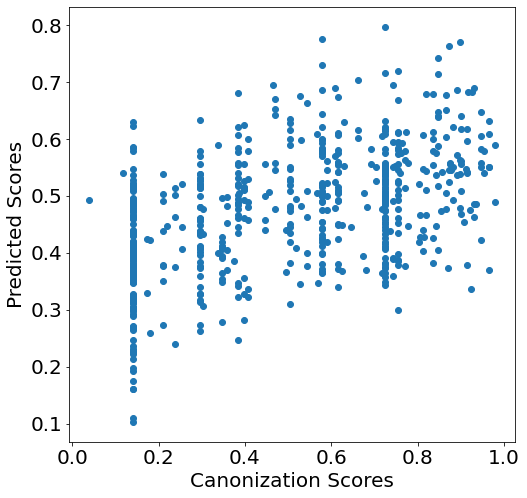

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
%matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter
import random
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
book_names = book_and_averaged_chunk_df["book_name"].values

book_and_averaged_chunk_df = book_and_averaged_chunk_df.drop(columns=["book_name"])
book_and_averaged_chunk_df = book_and_averaged_chunk_df[[column for column in book_and_averaged_chunk_df.columns if "average_sentence_embedding" not in column]]
best_features = book_and_averaged_chunk_df.columns[np.argwhere((rfe.ranking_ <= 12) == True).T[0]].tolist()
book_and_averaged_chunk_df = book_and_averaged_chunk_df[best_features]

df = book_and_averaged_chunk_df
df["y"] = np.array([labels[book_name] for book_name in book_names])
df["book_name"] = book_names

all_predictions = []
all_labels = []
train_mses = []
train_maes = []
validation_mses = []
validation_maes = []
validation_r2s = []

def split_booknames(df, nr_splits):
        '''
        Distribute book names over splits.
        All works of an author are in the same split.
        '''
        book_names = df['book_name'].unique()
        authors = []
        booknames_authors_mapping = {}

        #Get authors
        for book_name in book_names:
            author = '_'.join(book_name.split('_')[:2])
            authors.append(author)
            if author in booknames_authors_mapping:
                booknames_authors_mapping[author].append(book_name)
            else:
                booknames_authors_mapping[author] = []
                booknames_authors_mapping[author].append(book_name)
        #Distribute authors over splits so that each split has approximately the same number of books
        works_per_author = Counter(authors)
        goal_sum = round(len(book_names)/nr_splits)
        tolerance = 0.03
        lower_threshold = goal_sum - round(tolerance*goal_sum)
        upper_threshold = goal_sum + round(tolerance*goal_sum)
        author_splits = []
        for i in range (0,nr_splits-1):
            works_in_split = 0
            split = []
            while works_in_split < upper_threshold:
                curr_author = random.choice(list(works_per_author.keys()))
                curr_author_workcount = works_per_author.pop(curr_author)
                #Reinsert into dict if value is too high
                if works_in_split + curr_author_workcount > upper_threshold:
                    works_per_author[curr_author] = curr_author_workcount
                else:
                    split.append(curr_author)
                    works_in_split += curr_author_workcount
                    if works_in_split >= lower_threshold:
                        break
            author_splits.append(split)
        #Create last split directly from remaining dict
        works_in_last_split = sum(works_per_author.values())
        split = list(works_per_author.keys())
        author_splits.append(split)

        #Map author splits to book names
        book_splits = []
        for author_split in author_splits:
            book_split = []
            for author in author_split:
                book_split.extend(booknames_authors_mapping[author])
            book_splits.append(book_split)

        return book_splits

#book_names_split = np.array_split(book_names, 10)
book_names_split = split_booknames(df=df, nr_splits=10)
for index, split in enumerate(book_names_split):
    train_df = df[~df["book_name"].isin(split)]
    validation_df = df[df["book_name"].isin(split)]
    train_X = train_df.drop(columns=["y", "book_name"]).values
    train_y = train_df["y"].values.ravel()
    validation_X = validation_df.drop(columns=["y", "book_name"]).values
    validation_y = validation_df["y"].values.ravel()
    dtrain = xgboost.DMatrix(train_X, label=train_y)
    params = {"max_depth": 4, "learning_rate": 0.03, "colsample_bytree": 0.33, "min_child_weight": 6.0, "n_jobs": -1}
    model = xgboost.train(
        params,
        dtrain,
        num_boost_round=num_boost_round
    )

    train_books = deepcopy(train_df[["book_name", "y"]])
    train_books["yhat"] = model.predict(xgboost.DMatrix(train_X))
    validation_books = deepcopy(validation_df[["book_name", "y"]])
    validation_books["yhat"] = model.predict(xgboost.DMatrix(validation_X))

    train_books = train_books.groupby("book_name").mean()
    validation_books = validation_books.groupby("book_name").mean()

    train_y = train_books["y"].tolist()
    train_yhat = train_books["yhat"].tolist()
    validation_y = validation_books["y"].tolist()
    validation_yhat = validation_books["yhat"].tolist()

    all_labels.extend(validation_y)
    all_predictions.extend(validation_yhat)

    train_mse = mean_squared_error(train_y, train_yhat)
    train_mae = mean_absolute_error(train_y, train_yhat)
    validation_mse = mean_squared_error(validation_y, validation_yhat)
    validation_mae = mean_absolute_error(validation_y, validation_yhat)
    validation_r2 = r2_score(validation_y, validation_yhat)
    train_mses.append(train_mse)
    train_maes.append(train_mae)
    validation_mses.append(validation_mse)
    validation_maes.append(validation_mae)
    validation_r2s.append(validation_r2)
    print(f"Fold: {index+1}, TrainMSE: {np.round(train_mse, 3)}, TrainMAE: {np.round(train_mae, 3)}, ValMSE: {np.round(validation_mse, 3)}, ValMAE: {np.round(validation_mae, 3)}, ValR2: {np.round(validation_r2, 3)}")
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

mean_train_mse = np.mean(train_mses)
mean_train_mae = np.mean(train_maes)
mean_validation_mse = np.mean(validation_mses)
mean_validation_rmse = np.mean([sqrt(x) for x in validation_mses])
mean_validation_mae = np.mean(validation_maes)
mean_validation_r2 = np.mean(validation_r2s)

print("------")
print(f"Mean scores, TrainMSE: {np.round(mean_train_mse, 3)}, TrainMAE: {np.round(mean_train_mae, 3)}, ValMSE: {np.round(mean_validation_mse, 3)}, ValRMSE: {np.round(mean_validation_rmse, 3)}, ValMAE: {np.round(mean_validation_mae, 3)}, ValR2: {np.round(mean_validation_r2, 3)}")

plt.figure(figsize=(8, 8))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.scatter(all_labels, all_predictions)
plt.xlabel("Canonization Scores", fontsize=20)
plt.ylabel("Predicted Scores", fontsize=20)

plt.show();
